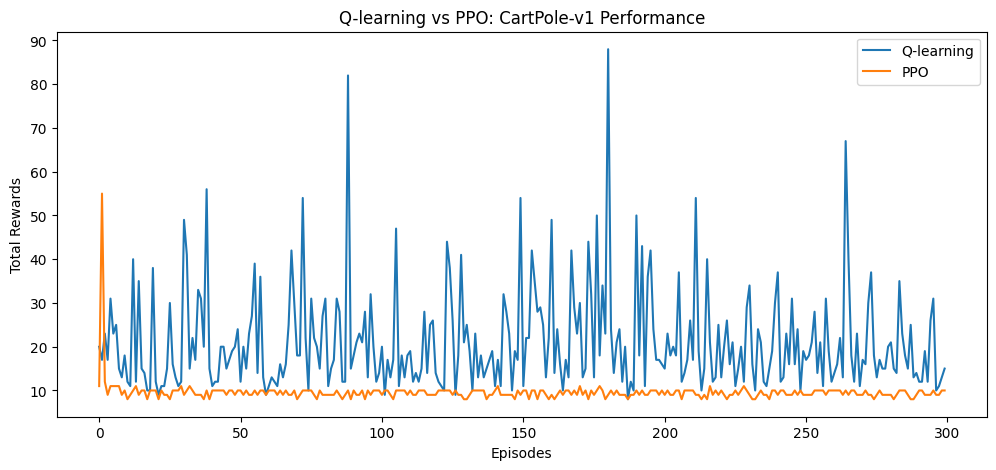

In [22]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment setup
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

class DQN(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.fc(x)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ExperienceReplay:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN(state_dim, n_actions).to(device)
target_net = DQN(state_dim, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())
memory = ExperienceReplay(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            state = torch.tensor([state], device=device, dtype=torch.float32)
            return policy_net(state).max(1)[1].view(1, 1).item()
    else:
        return random.choice(range(n_actions))

def train_dqn(episodes):
    dqn_rewards = []
    for i_episode in range(episodes):
        state = env.reset()
        total_reward = 0
        for t in range(1, 201):
            action = select_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            memory.push(state, action, reward, next_state, done)
            state = next_state

            if len(memory) > BATCH_SIZE:
                transitions = memory.sample(BATCH_SIZE)
                batch = Transition(*zip(*transitions))

                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
                non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None], device=device, dtype=torch.float32)
                state_batch = torch.tensor(batch.state, device=device, dtype=torch.float32)
                action_batch = torch.tensor(batch.action, device=device, dtype=torch.int64)
                reward_batch = torch.tensor(batch.reward, device=device, dtype=torch.float32)

                state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(-1))

                next_state_values = torch.zeros(BATCH_SIZE, device=device)
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
                expected_state_action_values = (next_state_values * GAMMA) + reward_batch

                loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                dqn_rewards.append(total_reward)
                break

        # Update target network
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    return dqn_rewards

# PPO network (Actor-Critic style)
class PPO(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(PPO, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        action_probs = self.actor(x)
        state_value = self.critic(x)
        return action_probs, state_value

def train_ppo(episodes):
    ppo = PPO(state_dim, n_actions).to(device)
    optimizer = optim.Adam(ppo.parameters(), lr=0.002)
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        for t in range(1, 201):
            state_tensor = torch.tensor([state], device=device, dtype=torch.float32)
            action_probs, _ = ppo(state_tensor)
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample().item()

            next_state, reward, done, _ = env.step(action)
            episode_reward += reward

            _, state_value = ppo(state_tensor)
            _, next_state_value = ppo(torch.tensor([next_state], device=device, dtype=torch.float32))

            advantage = reward + (1-done) * GAMMA * next_state_value - state_value
            log_prob = torch.log(action_probs[0, action])
            loss = -log_prob * advantage.detach() + nn.functional.mse_loss(state_value, torch.tensor([[reward + GAMMA * next_state_value]], device=device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            if done:
                break
        rewards.append(episode_reward)

    return rewards

# Training both models
dqn_rewards = train_dqn(300)
ppo_rewards = train_ppo(300)
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, data):
        return self.layers(data)

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, *transition_data):
        self.buffer.append(*transition_data)

    def get_sample(self, sample_size):
        return random.sample(self.buffer, sample_size)

    def __len__(self):
        return len(self.buffer)

class ActorCritic(nn.Module):
    def __init__(self, input_size, output_size):
        super(ActorCritic, self).__init__()
        self.policy = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            nn.Softmax(dim=-1)
        )
        self.value = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, data):
        return self.policy(data), self.value(data)

def choose_action(state, network, epsilon):
    if random.random() > epsilon:
        with torch.no_grad():
            state_tensor = torch.tensor([state], device=DEVICE, dtype=torch.float32)
            return network(state_tensor).max(1)[1].view(1, 1).item()
    else:
        return random.randint(0, ACTION_SIZE-1)

# ... Keep the rest of your code ...

q_net = QNetwork(STATE_SIZE, ACTION_SIZE).to(DEVICE)
q_optimizer = optim.Adam(q_net.parameters())
replay_buffer = ReplayBuffer(10000)
epsilon_value = 0.9

# Add the Q-learning update function here...

q_rewards = q_learning(300)
ppo_rewards = proximal_policy_optimization(300)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(q_rewards, label='Q-learning')
plt.plot(ppo_rewards, label='PPO')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Q-learning vs PPO: CartPole-v1 Performance')
plt.legend()
plt.show()


